# Pytorch Paper Replicating

The goal of Machine Learning Paper replicating is turn a ML research paper into usable code

In this notebook we're going to replicate the Vision Transformer (VIT) paper with Pytorch

## 0 Get Setup

Let's import code used already and libraies

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1534/1534), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 4393 (delta 1457), reused 1401 (delta 1401), pack-reused 2859 (from 2)
Receiving objects: 100% (4393/4393), 650.71 MiB | 37.73 MiB/s, done.
Resolving deltas: 100% (2659/2659), done.
Updating files: 100% (248/248), done.


In [3]:
# setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


'cuda'

## 1 Get Data

The whole goal of what we're trying to do is to replicate the vision transformer for our food vision mini prolem

To do that, we need some data namely the pizza steak and sushi images we've been working with

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2 Create Datasets and Datloaders

In [6]:
from going_modular.going_modular import data_setup
from torchvision import transforms

In [7]:
# create image size
IMAGE_SIZE = 224
BATCH_SIZE = 32

# create transfomrs pipeline
manual_transforms = transforms.Compose([
    transforms.Resize(size = (IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [8]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform = manual_transforms,
                                                                               batch_size = BATCH_SIZE)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.1 Visualize a Single Image

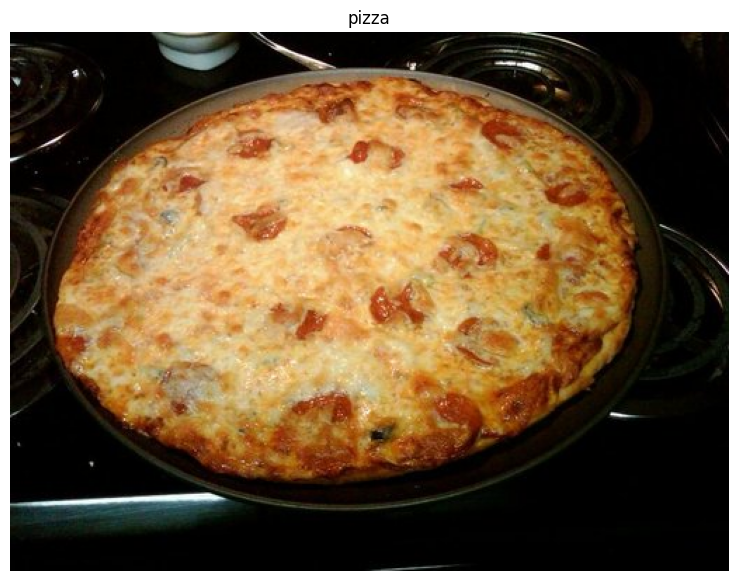

In [9]:
import random
from PIL import Image
import numpy as np

random.seed(42)

image_path_list = list(train_dir.glob('*/*.jpg'))
random_image_path = random.choice(image_path_list)
random_image_path

# open image
test_image = Image.open(random_image_path)
image_class = random_image_path.parent.stem

# plot the image
img_as_array = np.asarray(test_image)
plt.figure(figsize =(10,7))
plt.imshow(img_as_array)
plt.title(image_class)
plt.axis(False);

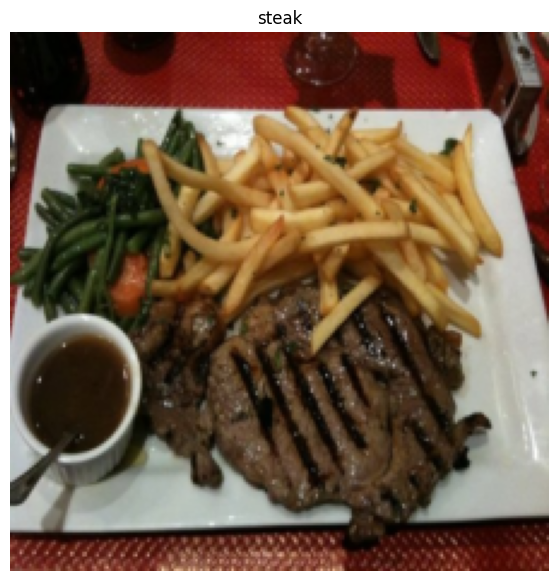

In [10]:
import random
random.seed(42)

# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# get a simgle image and label from the batch
random_idx = random.choice(range(len(image_batch)))
image, label = image_batch[random_idx], label_batch[random_idx]

# plot image and label
plt.figure(figsize =(10,7))
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

## 3 Replicating VIT Overview

Looking at a whole machine learning research paper can be intimidating

To make it more understandable, we can break it down into smaller pieces

* **Inputs** - What goes into the model
* **Outputs** - What comes out of the model/label/block
* **Layers** - Takes an input, manipulates it with a function (self attention in this case)
* **Blocks** - A collection of layers
* **Model** - A collection of blocks

### 3.1 VIT Overview Pieces of the Puzzle

* Figure 1 - visual overview of the architecture
* Four equations which define the function of each layer/block
* Table 1 different hyperparameters for the archtecture
* Text

#### Figure 1
![](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-figure-1-architecture-overview.png?raw=true)

* Embeddings = learnable representations (start with random numbers and improve over time)

#### Four Equations
![](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-four-equations.png?raw=true)


```python
# equation 1
x_input = [class_token, image_patch_1, image_patch_2, ..., image_patch_N] + [class_token_pos, image_patch_1_pos, image_patch_2_pos, ...,image_patch_N_pos ]

#equation 2
x_output_msa_block = MSA_layer(LN_layer(x_input)) + x_input

# equation 3
x_output_MLP_block = MLP_layer(LN_layer(x_output_msa_block)) + x_output_msa_block
```

MLP = multilayer percetron a neural network with X number of layers
MLP = one hidden unit at training time
MLP = single linear layer at fine tuning time

In psuedocode
```python
# equation 4
y_output = Linear_layer(LN_layer(x_output_MLP_block))
```

#### table 1
![](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-table-1.png?raw=true)

* VIT Base VIT large and VIT huge are all different sizes of the same model architecture
* Layers - the number of transformer encoder layers
* Hidden size $D$ - the embedding size throughout the archtecture
* MLP Size - the number of hidden units in the MLP
Heads - the number of multihead self attention

## 4 Equation 1. Split Data into patches and creating the class position and class embedding

Layers = input -> function -> output

What's the input shape

What's the output shape

* input shape is a single image of (224, 224, 3)
* Output shape


* Input Shape: $H\times{W}\times{C}$
* Output Shape: $N\times\left({P^2}\cdot {C}\right)$

* H = height
* W: width
* C: color channels
* P: patch size
* N: Number of patches = $\left(H\times{W}\right) \over {P^2}$
* D: constant latent vector size = embeddind dimension

In [11]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate number of patches
number_of_patches = int((height * width) / patch_size**2)

number_of_patches

196

In [12]:
# input shape
embedding_layer_input_shape = (height, width, color_channels)

# output shape
embedding_layer_output_shape = (number_of_patches, (patch_size**2 * color_channels))

print(f'Input Shape (single 2D image): {embedding_layer_input_shape}')
print(f'Output SHape (single 1D sequence of patches): {embedding_layer_output_shape}')

Input Shape (single 2D image): (224, 224, 3)
Output SHape (single 1D sequence of patches): (196, 768)


### 4.1 Turn a Single Image into Patches

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

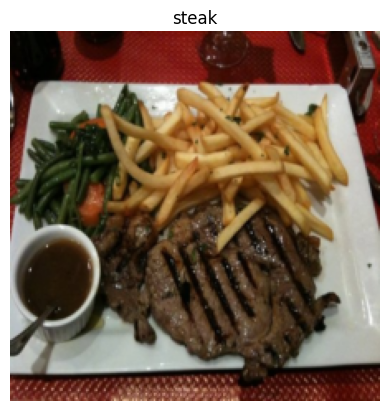

In [13]:
# View a single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [14]:
image.shape

torch.Size([3, 224, 224])

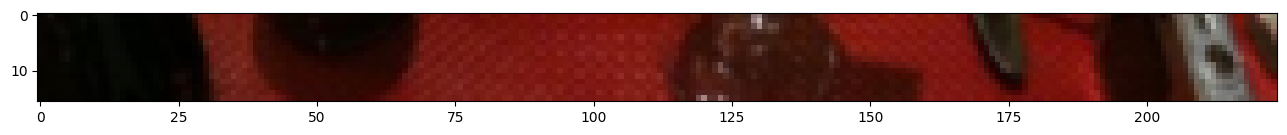

In [15]:
# Get the top row of the image
image_permuted = image.permute(1,2,0) # change to format compatible with matplotlib

# index to plot the top row of pixels
patch_size =16
plt.figure(figsize =(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])


Number of patches per row: 14.0
Patch Size: 16 pixels x 16 pixels


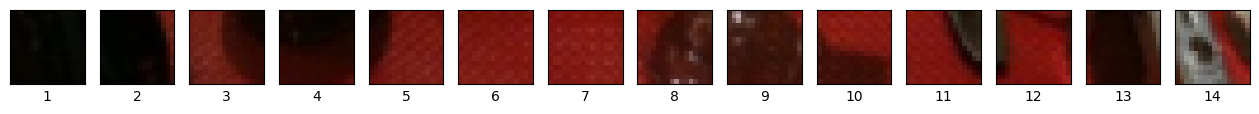

In [16]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, 'Image size must be divisible by patch size'
print(f"Number of patches per row: {num_patches}\nPatch Size: {patch_size} pixels x {patch_size} pixels")


# Create a series of subplots
fig, ax = plt.subplots(nrows= 1,
                       ncols= img_size // patch_size,
                       sharex=True,
                       sharey=True,
                       figsize = (patch_size, patch_size))

# iterate through the number of patches in te top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  ax[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
  ax[i].set_xlabel(i+1)
  ax[i].set_xticks([])
  ax[i].set_yticks([]);

In [17]:
# Create patches of the entire image
print(f"Image size: {img_size, img_size, color_channels}")
print(f"Number of patches per row: {num_patches}\nNumber of patches per column: {num_patches}\nPatch Size: {patch_size} pixels x {patch_size} pixels")

fig, ax = plt.subplots(nrows= img_size // patch_size,
                       ncols= img_size // patch_size,
                       sharex=True,
                       sharey=True,
                       figsize = (img_size, img_size))

for i, horizontal_patch in enumerate(range(0, img_size, patch_size)):
  for j, vertical_patch in enumerate(range(0, img_size, patch_size)):
    # ax = ax[i,j]
    ax[i,j].imshow(image_permuted[
                             horizontal_patch: horizontal_patch + patch_size,
                             vertical_patch:vertical_patch + patch_size,
                             :])
    # ax[i,j].set_xlabel(f'{(j+1, i+1)}')

    ax[i,j].set_xticks([])
    ax[i,j].set_yticks([]);



Image size: (224, 224, 3)
Number of patches per row: 14.0
Number of patches per column: 14.0
Patch Size: 16 pixels x 16 pixels


### 4.2 Creating image patches and turning them into embeddings

Perhaps we counld create the image patches and embeddins in a single step using `torch.nn.Conv2D()` and setting the kernel and padding parameters to `patch_size`

In [18]:
# create conv2D layer to create patches of learnable feature maps
from torch import nn

# set patch size
patch_size = 16

# create conv2D layer with hyperparameters from the VIT paper
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

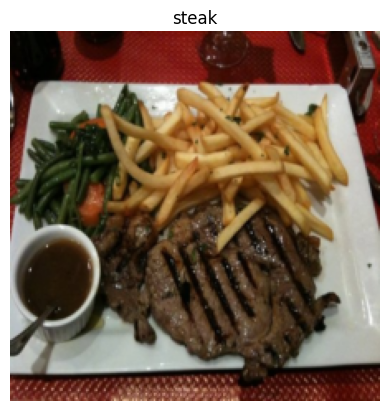

In [19]:
# view a single image
plt.imshow(image_permuted)
plt.title(class_names[label])
plt.axis(False)

In [20]:
# pass image through the convolution layer
Image_out_of_conv_layer = conv2d(image.unsqueeze(0))
print(Image_out_of_conv_layer.shape)

torch.Size([1, 768, 14, 14])


Now we've passed a single image through our conv2d layer. It's shape is

```python
torch.Size([1, 768, 14, 14])
# (batch_size, embedding dim, feature amp height, featur map width)
```

SHowing random feature maps from indexes: [25, 759, 281, 250, 228]


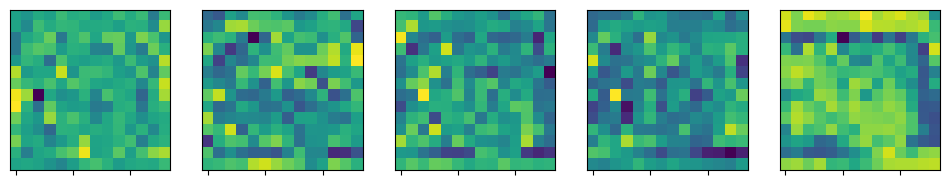

In [21]:
# plot random convolutiona feature
import random
random_indexes = random.sample(range(0,768), k=5)
print(f'SHowing random feature maps from indexes: {random_indexes}')

# create plots
fig, ax = plt.subplots(nrows=1, ncols=5, figsize = (12,12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
  image_conv_feature_map = Image_out_of_conv_layer[:, idx, :, :]
  ax[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
  ax[i].set(xticklabels =[], yticklabels = [], yticks = []);

In [22]:
# get a single feature map in tensor orm
single_feature_map = Image_out_of_conv_layer[:,0,:,:]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-2.4181e-02, -7.6029e-03, -1.8751e-02, -1.1308e-02,  6.0850e-02,
            1.5374e-02,  8.4830e-04, -5.0456e-02, -4.9063e-02,  8.2535e-04,
           -1.8944e-02,  7.8169e-02, -4.1305e-02,  4.4132e-02],
          [-4.3382e-02,  4.9975e-02, -1.9938e-02, -6.9306e-03,  9.3536e-03,
            6.9718e-03, -2.4298e-03, -3.3837e-02,  2.8543e-03,  1.9894e-03,
            9.2325e-03, -1.1198e-02, -1.9139e-02,  9.4656e-02],
          [ 1.7348e-02, -4.6767e-02, -8.4203e-02, -6.9390e-02, -1.1575e-01,
            6.2781e-02,  4.8272e-02,  8.0067e-02,  7.8294e-02, -4.5262e-02,
            3.4045e-02, -1.6929e-02,  1.2426e-01,  3.7784e-03],
          [-1.0341e-02, -1.1805e-01,  3.7952e-02, -8.1025e-02, -4.3254e-02,
            3.9933e-02, -3.6963e-02, -3.2213e-02,  1.3107e-02,  1.5168e-03,
           -4.3189e-02, -1.5027e-01, -2.0582e-02, -2.4060e-02],
          [ 2.0855e-02, -2.6429e-03, -1.1134e-04, -2.0102e-03,  4.1512e-04,
            1.5991e-03,  6.6450e-02,  2.7272e-02, -1.0459e-0

### 4.3 Flattening the patch embedding with `torch.nn.Flatten()`

Rigt now we have a series of convolutional feature maps (embeddings) that we want to flatten into a sequence of patch embeddings to satisfy the input criteria of the VIT transformer

In [23]:
print(f'{Image_out_of_conv_layer.shape} ->  \
\n(batch_size, embedding_dim, feature_map_height, feature_map_width)')

torch.Size([1, 768, 14, 14]) ->  
(batch_size, embedding_dim, feature_map_height, feature_map_width)


We want: (batch_size, number_of_patches, embedding_dim)

In [24]:
flatten_layer = nn.Flatten(start_dim=2,
                           end_dim=3)
flatten_layer(Image_out_of_conv_layer).shape

torch.Size([1, 768, 196])

Original Image Shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened imae feature map shape: torch.Size([1, 768, 196])


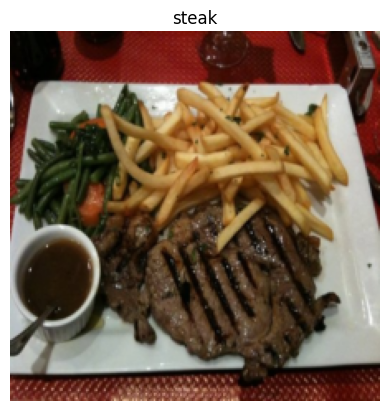

In [25]:
# put everything together
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
print(f'Original Image Shape: {image.shape}')

# turn image into feature maps
Image_out_of_conv_layer = conv2d(image.unsqueeze(0)) # adds a batch dimension
print(f'Image feature map shape: {Image_out_of_conv_layer.shape}')

# flatten the feature maps
image_out_of_flatten_layer = flatten_layer(Image_out_of_conv_layer)
print(f'Flattened imae feature map shape: {image_out_of_flatten_layer.shape}')

In [26]:
# rearranged output of flattened layer
image_out_of_conv_flattened_reshaped = image_out_of_flatten_layer.permute(0,2,1)
image_out_of_flatten_layer.permute(0,2,1).shape

torch.Size([1, 196, 768])

(np.float64(-0.5), np.float64(195.5), np.float64(0.5), np.float64(-0.5))

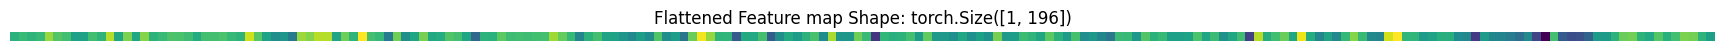

In [27]:
# get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:,:,0]

# plot the flattened feature map
plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f'Flattened Feature map Shape: {single_flattened_feature_map.shape}')
plt.axis(False)

### 4.4 Turning the VIT Patch EMbedding Layer into a Pytorch Module

We want this module to do a few things:
1. create a class called `PatchEmbedding`
2. Initialize with appropriate hyperparameters such as channels, embedding dim, patch size
3. Create a layer to turn an image into patches using  `nn.Conv2D()`
4. Create a layer to flatten the feature maps of the output of the layer in 3
5. define a `forward()` method
6. Make sure the out shpae reflects the output shape of he patch embedding

In [28]:
from types import resolve_bases
# 1 create patch embeeding class
class PatchEMbedding(nn.Module):
  # initialize wit appropriate hyperparameters
  def __init__(self,
               in_channels: int = 3,
               embedding_dim: int = 768,
               patch_size: int = 16) -> None:

    self.patch_size = patch_size

    super().__init__()

    # create layer to turn images into patches
    self.conv_layer = nn.Conv2d(in_channels=in_channels,
                                out_channels=embedding_dim,
                                stride=patch_size,
                                kernel_size=patch_size,
                                padding=0)

    # create a layer to flatten feature maps
    self.flatten_layer = nn.Flatten(start_dim=2,
                                    end_dim=3)

  def forward(self, x):
    # create assertion to check that inputs are correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f'Input image size must be divisible by patch size. Image Shape: {image_resolution} patch size is {self.patch_size}'
    x = self.conv_layer(x)
    x = self.flatten_layer(x)
    return x.permute(0,2,1)




In [29]:
set_seeds()

# creat PatchEmbedding instance
patchify = PatchEMbedding(3, 768, 16)

# pass a single image
print(f'Input Image Size: {image.unsqueeze(0).shape}')
patch_embedded_image = patchify(image.unsqueeze(0))
print(f'Output Patch EMbedding shape: {patch_embedded_image.shape}')

Input Image Size: torch.Size([1, 3, 224, 224])
Output Patch EMbedding shape: torch.Size([1, 196, 768])


### 4.5 Creating the Class Token Embedding

We want to prepend a learnable class token embedding to the start of the patch embedding

In [30]:
patch_embedded_image

tensor([[[-4.9274e-02, -1.2502e-04, -3.5572e-02,  ...,  1.1833e-02,
          -1.2263e-02,  2.4581e-02],
         [-6.7786e-02,  5.7727e-02, -5.2555e-02,  ...,  1.9184e-02,
          -7.7774e-02,  8.0018e-03],
         [-1.4700e-01, -5.3285e-02, -3.3463e-02,  ...,  2.2622e-02,
          -6.2656e-02,  2.1706e-01],
         ...,
         [-2.5101e-01, -4.8922e-02, -3.0782e-02,  ...,  2.0408e-01,
          -1.1166e-01,  1.8546e-01],
         [-1.9574e-01, -3.1517e-02, -2.3149e-02,  ...,  4.5486e-02,
          -1.0676e-01,  1.2881e-01],
         [-3.2620e-01, -6.5398e-03, -8.1226e-03,  ...,  1.0947e-01,
          -1.3815e-01,  1.0507e-01]]], grad_fn=<PermuteBackward0>)

In [31]:
# get batch size and embedding dinmenion
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [32]:
# create a class token embedding as a learnable parameter
# that shares the same size as the embedding dimension
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
class_token.shape


torch.Size([1, 1, 768])

In [33]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [34]:
# Add class token embedding to the front of the patch embeddion
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1)

print(patch_embedded_image_with_class_embedding)
print(f'Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape}')

tensor([[[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
           1.0000e+00,  1.0000e+00],
         [-4.9274e-02, -1.2502e-04, -3.5572e-02,  ...,  1.1833e-02,
          -1.2263e-02,  2.4581e-02],
         [-6.7786e-02,  5.7727e-02, -5.2555e-02,  ...,  1.9184e-02,
          -7.7774e-02,  8.0018e-03],
         ...,
         [-2.5101e-01, -4.8922e-02, -3.0782e-02,  ...,  2.0408e-01,
          -1.1166e-01,  1.8546e-01],
         [-1.9574e-01, -3.1517e-02, -2.3149e-02,  ...,  4.5486e-02,
          -1.0676e-01,  1.2881e-01],
         [-3.2620e-01, -6.5398e-03, -8.1226e-03,  ...,  1.0947e-01,
          -1.3815e-01,  1.0507e-01]]], grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768])


### 4.6 Creating the Positional Embedding

Want to create a series of 1D learnable positional embedddings and add them to the sequence of patch embeddings

In [35]:
# view the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape


(tensor([[[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
            1.0000e+00,  1.0000e+00],
          [-4.9274e-02, -1.2502e-04, -3.5572e-02,  ...,  1.1833e-02,
           -1.2263e-02,  2.4581e-02],
          [-6.7786e-02,  5.7727e-02, -5.2555e-02,  ...,  1.9184e-02,
           -7.7774e-02,  8.0018e-03],
          ...,
          [-2.5101e-01, -4.8922e-02, -3.0782e-02,  ...,  2.0408e-01,
           -1.1166e-01,  1.8546e-01],
          [-1.9574e-01, -3.1517e-02, -2.3149e-02,  ...,  4.5486e-02,
           -1.0676e-01,  1.2881e-01],
          [-3.2620e-01, -6.5398e-03, -8.1226e-03,  ...,  1.0947e-01,
           -1.3815e-01,  1.0507e-01]]], grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [36]:
# caluclate number of patches
number_of_patches = int((height * width) / patch_size**2)

# get the embeddding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# create learnable 1D positional embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches + 1,
                                             embedding_dimension))

position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [37]:
# add position embeddings to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
patch_and_position_embedding, patch_and_position_embedding.shape

(tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
          [0.9507, 0.9999, 0.9644,  ..., 1.0118, 0.9877, 1.0246],
          [0.9322, 1.0577, 0.9474,  ..., 1.0192, 0.9222, 1.0080],
          ...,
          [0.7490, 0.9511, 0.9692,  ..., 1.2041, 0.8883, 1.1855],
          [0.8043, 0.9685, 0.9769,  ..., 1.0455, 0.8932, 1.1288],
          [0.6738, 0.9935, 0.9919,  ..., 1.1095, 0.8619, 1.1051]]],
        grad_fn=<AddBackward0>),
 torch.Size([1, 197, 768]))

### 4.8 Putting it all togeether from image to Embedding

In [38]:
# set seeds
set_seeds()

# set the patch size
patch_size = 16

# print shapes of the original image tensor and get the image dimension
print(f'Image tesnor shape: {image.shape}')
height, width = image.shape[1], image.shape[2]

# get the image tensor and add a bach dimension
x = image.unsqueeze(0)
print(f'Input image SHape: {x.shape}')

# create patch embedding layer
patch_embedding_layer = PatchEMbedding(in_channels=3,
                                       embedding_dim=768,
                                       patch_size=patch_size)

# Pass input image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f'Patch Embedding SHape: {patch_embedding.shape}')

# create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)

print(f'Class token EMbedding Shape: {class_token.shape}')

# prepend the class token ebedding to the clas embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f'Patch Ebedding wit class token shape: {patch_embedding_class_token.shape}')

# create positional token embeddings
number_of_patches = int((height * width) / patch_size **2)
position_embedding = nn.Parameter(torch.ones(batch_size,
                                             number_of_patches+ 1,
                                             embedding_dimension),
                                  requires_grad=True)

# Add the postional embeding to the patch and class token embedding
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f'patch and Position Embedding Shape: {patch_and_position_embedding.shape}')

Image tesnor shape: torch.Size([3, 224, 224])
Input image SHape: torch.Size([1, 3, 224, 224])
Patch Embedding SHape: torch.Size([1, 196, 768])
Class token EMbedding Shape: torch.Size([1, 1, 768])
Patch Ebedding wit class token shape: torch.Size([1, 197, 768])
patch and Position Embedding Shape: torch.Size([1, 197, 768])


## 5 Equation 2 Multihead Self Attention Block)

* Which part of te sequence should pay the most attention to itself?

  * In our case, we have a series of embedded image patches, which patch significantly relates to another patch.
  * We want our VIT to learn this relationship/representation
* Layer Norm = is a technique to normalize the distributions of intermediate layers. It enables smoother gradients , faster training and beter generalization.
  * Normalization = make everything have the same mean and standard deviation
  * Normalize over $D$ dmension. in ur case $D$ is our embedding dimension
    * when we normalize over the embedding dimension, it's like making all all the stairs in a staircase the same size

In [39]:
class MultiHeadSelfAttentionBlock(nn.Module):
  '''
  Creates a multi head self attention block
  '''
  def __init__(self,
               embedding_dim: int = 768,
               num_heads: int = 12, # heads from table 1
               attn_dropout: int = 0) -> None:
     super().__init__()
     # create the norn layer
     self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

     # create multi head attention layer
     self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 dropout=attn_dropout,
                                                 batch_first=True)

  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attn(query = x,
                                         key = x,
                                         value = x,
                                         need_weights = False)
    return attn_output

In [40]:
# create an instance of MSA block
multohead_self_attn_block = MultiHeadSelfAttentionBlock(embedding_dim=768,
                                                        num_heads=12)

# pas the patch and position embedding through MSA block
patched_image_thru_msa_block = multohead_self_attn_block(patch_and_position_embedding)
print(f'Input shape of MSA block: {patch_and_position_embedding.shape}')
print(f'Ouput shape of MSA block: {patched_image_thru_msa_block.shape}')


Input shape of MSA block: torch.Size([1, 197, 768])
Ouput shape of MSA block: torch.Size([1, 197, 768])


In [41]:
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.9507, 0.9999, 0.9644,  ..., 1.0118, 0.9877, 1.0246],
         [0.9322, 1.0577, 0.9474,  ..., 1.0192, 0.9222, 1.0080],
         ...,
         [0.7490, 0.9511, 0.9692,  ..., 1.2041, 0.8883, 1.1855],
         [0.8043, 0.9685, 0.9769,  ..., 1.0455, 0.8932, 1.1288],
         [0.6738, 0.9935, 0.9919,  ..., 1.1095, 0.8619, 1.1051]]],
       grad_fn=<AddBackward0>)

In [42]:
patched_image_thru_msa_block

tensor([[[-0.1890, -0.2311,  0.0554,  ..., -0.3979,  0.8380, -0.4527],
         [-0.1940, -0.2449,  0.0549,  ..., -0.3778,  0.8486, -0.4587],
         [-0.1833, -0.2601,  0.0359,  ..., -0.3745,  0.8500, -0.4678],
         ...,
         [-0.1860, -0.2318,  0.0557,  ..., -0.3823,  0.8521, -0.4756],
         [-0.1827, -0.2360,  0.0492,  ..., -0.3793,  0.8525, -0.4774],
         [-0.1817, -0.2338,  0.0511,  ..., -0.3739,  0.8521, -0.4833]]],
       grad_fn=<TransposeBackward0>)

## 6 MultiLayer Perceptron (MLP Block)

* **MLP** - contains two layers with the GELU non-linearity
  * MLP is a broad termfor a block with a series of layers
  * layers can mean; fully-connected, dense, linear, feed forward
  

In pusedocode
```python
# MLP
x = Linear -> non-Linear -> Dropout -> Linear -> Non- Linear
```

In [43]:
class MLPBlock(nn.Module):
  def __init__(self,
               embedding_dim: int = 768,
               mlp_size: int = 3072,
               dropout: float= 0.1) -> None:
     super().__init__()

     # create the norm layer
     self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

     # create mlp block
     self.mlp_block = nn.Sequential(
         nn.Linear(in_features=embedding_dim,
                   out_features=mlp_size),
         nn.GELU(),
         nn.Dropout(p=dropout),
         nn.Linear(in_features=mlp_size,
                   out_features=embedding_dim),
        #  nn.GELU(),
         nn.Dropout(p=dropout)
     )

  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp_block(x)
    return x



In [44]:
# create an instnce of MLP Block
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

# pass ouput of MSA block through MLP Block
patched_image_thru_mlp_block = mlp_block(patched_image_thru_msa_block)
print(f'Input shape of MLP Block: {patched_image_thru_msa_block.shape}')
print(f'Output shape of MLP Block: {patched_image_thru_mlp_block.shape}')

Input shape of MLP Block: torch.Size([1, 197, 768])
Output shape of MLP Block: torch.Size([1, 197, 768])


## 7 Creating the Transformer Encoder

The transformer encoder is a combination of alternating blocks of MSA and MLP

There are residual connections between each block

* Encoder - turn a sequence into a learnable repreentation
* Decoder - Go from learned representation back to some sort of sequence
Residual Connections - add a layer's input to its subsequent output. This enables the creation of deeper networks and prevents weights from getting too small


In pusedocode
```python
# tranformer encoder
x_input -> MSA_Block -> (MSA_Block_output + x_input) -> MLP_Block -> (MLP_Block_output + MSA_Block_output +  x_input) -> ...
```

### 7.1 Create a Custom Transformer Encoder Block

In [45]:
class TransformerEncoder(nn.Module):
  def __init__(self,
               embedding_dim: int= 768,
               num_heads: int =12,
               mlp_size: int = 3072,
               attn_dropot: float = 0,
               dropout: float = 0.1) -> None:
     super().__init__()
     self.msa = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                            num_heads=num_heads,
                                            attn_dropout=attn_dropot)

     self.mlp = MLPBlock(embedding_dim=embedding_dim,
                         mlp_size=mlp_size,
                         dropout=dropout)

  def forward(self, x):
    x = self.msa(x) + x
    x = self.mlp(x) + x
    return x

In [46]:
# an insance of transformer encoder block
transformer_encoder_block = TransformerEncoder()

# get a summary using torchinfo.summary
summary(transformer_encoder_block,
        input_size=(1,197,768),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])


Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoder (TransformerEncoder)            [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa)                [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp)                                   [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp_block)                      [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### 7.2 Create a Transformer Layeer with in Built PyTorch Layers

In [47]:
# create the same as above with nn.TransformerEncoderLayer
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                             nhead=12,
                                                             dim_feedforward=3072,
                                                             dropout=0.1,
                                                             activation='gelu',
                                                             batch_first=True,
                                                             norm_first=True)

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [48]:
summary(torch_transformer_encoder_layer,
        input_size=(1,197,768),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

## 8 Putting it all Together to create VIT

In [49]:
# create a VIT class
class VIT(nn.Module):
  def __init__(self,
               img_size: int = 224,
               in_channels: int =3,
               patch_size :int = 16,
               num_transformer_layers: int =12,
               embedding_dim : int = 768,
               mlp_size: int = 3072,
               num_heads: int = 12,
               attn_dropout: float= 0,
               mlp_dropout: float = 0.1,
               embedding_dropout: float = 0.1,
               num_classes: int = 1000) -> None:
     super().__init__()
     # 1 make an assertion that the image size is compatible with patch size
     assert img_size % patch_size == 0, f'Image size must be divisble by patch size. Image Size: {img_size}, Patch Size {patch_size}'

     # 2 calculate the number of patches (height * width / patch ^2)
     self.num_patches = (img_size * img_size) // patch_size**2

     # 3 create learnable class embedding
     self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                         requires_grad=True)

     # 4 create learning position embedding
     self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, embedding_dim),
                                       requires_grad=True)

     # 5 create embedding dropout value
     self.embedding_dropout = nn.Dropout(p=embedding_dropout)

     # 6 patch embedding layer
     self.patch_embedding = PatchEMbedding(in_channels=in_channels,
                                           embedding_dim=embedding_dim,
                                           patch_size=patch_size)

     # 7 create the transformer encoder block
     self.transformer_encoder = nn.Sequential(* [TransformerEncoder(embedding_dim=embedding_dim,
                                                                    num_heads=num_heads,
                                                                    mlp_size=mlp_size,
                                                                    attn_dropot=attn_dropout,
                                                                    dropout=mlp_dropout) for _ in range(num_transformer_layers)])

     # 8 create classifier head
     self.classifier = nn.Sequential(
         nn.LayerNorm(normalized_shape=embedding_dim),
         nn.Linear(in_features=embedding_dim,
                   out_features=num_classes)
     )

  def forward(self, x):
    # get batch_size
    batch_size = x.shape[0]

    # create class token embedding an expand it to matc batch size
    class_token = self.class_embedding.expand(batch_size, -1, -1)

    # create patch embedding
    x = self.patch_embedding(x)

    # concat class token embedding and patch embedding
    x = torch.cat((class_token, x), dim=1)

    # Add position embedding to class token and patch embedding
    x = self.pos_embedding + x

    # Apply dropout to patch embeddings
    x = self.embedding_dropout(x)

    # pass our position and patch embedding to encoder
    x = self.transformer_encoder(x)

    # put the 0th index logit through the classifier
    x = self.classifier(x[:, 0])

    return x



In [50]:
set_seeds()

# create random image tensor with same sape as images
random_image_tensor = torch.randn(1,3,224,224)

# create instance of VIT architecture
vit = VIT(num_classes=len(class_names))

# pass rando image to our VIT model
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

In [51]:
summary(vit,
        input_size=(1,3,224,224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VIT (VIT)                                                    [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEMbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (conv_layer)                                   [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten_layer)                               [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoder (0)                                [1, 197, 768]        [1, 197, 768] 

## 9 Setting up training code for our VIT architecture

### 9.1 creating an optimizer

In [52]:
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr = 1e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.1)



### 9.2 create a loss function

In [53]:
loss_fn = nn.CrossEntropyLoss()

### 9.3 Training our VIT model

In [54]:
from going_modular.going_modular import engine

In [55]:
results = engine.train(model=vit,
                       train_dataloader = train_dataloader,
                       test_dataloader = test_dataloader,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       epochs = 10,
                       device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.2338 | train_acc: 0.2812 | test_loss: 1.5526 | test_acc: 0.1979
Epoch: 2 | train_loss: 1.5796 | train_acc: 0.3047 | test_loss: 1.3806 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.1761 | train_acc: 0.4141 | test_loss: 4.0468 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.8344 | train_acc: 0.3867 | test_loss: 1.7689 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.3029 | train_acc: 0.2617 | test_loss: 1.0974 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.1955 | train_acc: 0.3438 | test_loss: 1.1466 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.2104 | train_acc: 0.2344 | test_loss: 1.5358 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.1126 | train_acc: 0.4219 | test_loss: 2.1112 | test_acc: 0.1979
Epoch: 9 | train_loss: 1.3194 | train_acc: 0.3164 | test_loss: 1.6852 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.5515 | train_acc: 0.2852 | test_loss: 1.4252 | test_acc: 0.2604


### 9.4 What our training setup is missing

The main thing our training implementation is mssing is scale. Our training setup uses substantially less data than the VIT paper

### 9.5 Plotting Loss Curves


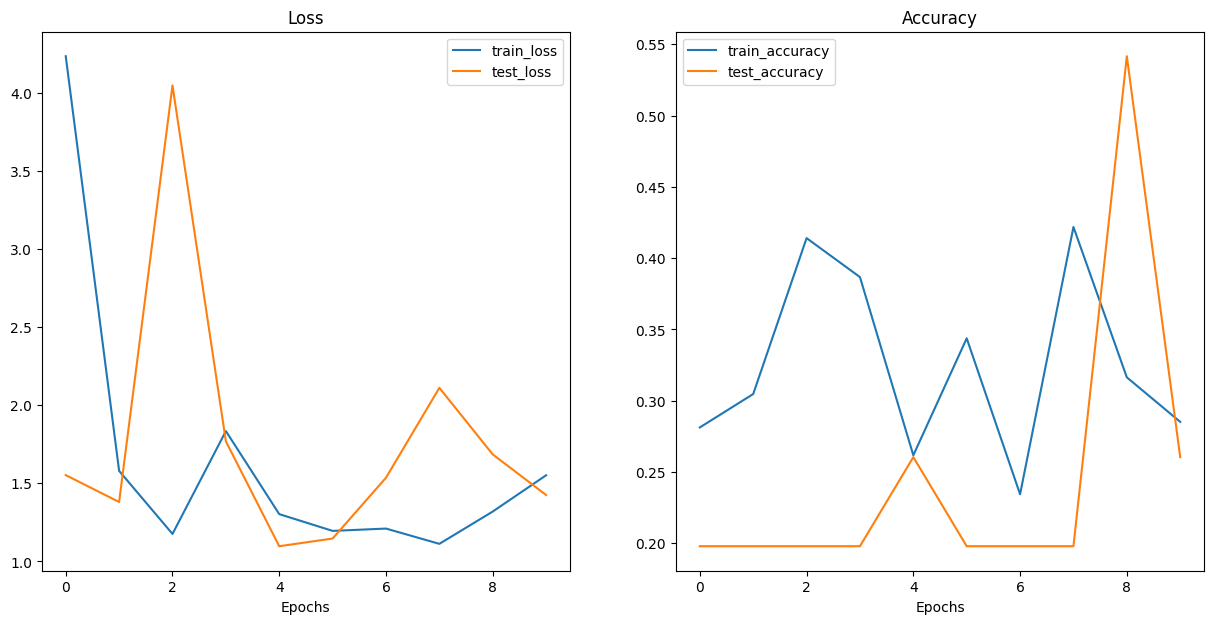

In [56]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

## 10 Using a pretrained model

Generally, in deep learning if you can use a pretrained model from a large dataset, it is often a good plae to start

In [57]:
import torch, torchvision
print(torch.__version__)
print(torchvision.__version__)

2.6.0+cu124
0.21.0+cu124


In [64]:
# get pretrained weights for vit base
vit_base_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# vit model instance
pretrained_vit = torchvision.models.vit_b_16(weights=vit_base_weights).to(device)

# freeze base params
for parameter in pretrained_vit.parameters():
  parameter.requires_grad = False

# update classifier head
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)


In [65]:
pretrained_vit.heads

Linear(in_features=768, out_features=3, bias=True)

In [66]:
summary(pretrained_vit,
        input_size=(1,3,224,224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 10.1 Preparing data for the pretrained model

When using a pretrained model, we need to make surre that the data is prepared in the same format

In [67]:
# get automatic transforms from pretrained vit weights
vit_transforms = vit_base_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [68]:
# setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir = test_dir,
                                                                                                     transform = vit_transforms,
                                                                                                     batch_size = 32)

### 10.2 Train Feature Extractor VIT Model

In [69]:
# train model

optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr = 1e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.1)

results_1 = engine.train(model=pretrained_vit,
                         train_dataloader = train_dataloader_pretrained,
                         test_dataloader = test_dataloader_pretrained,
                         optimizer = optimizer,
                         loss_fn = loss_fn,
                         epochs = 10,
                         device= device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7834 | train_acc: 0.6602 | test_loss: 0.5551 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3978 | train_acc: 0.9375 | test_loss: 0.3181 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2171 | train_acc: 0.9453 | test_loss: 0.3070 | test_acc: 0.8987
Epoch: 4 | train_loss: 0.1712 | train_acc: 0.9570 | test_loss: 0.2637 | test_acc: 0.8987
Epoch: 5 | train_loss: 0.1465 | train_acc: 0.9609 | test_loss: 0.2302 | test_acc: 0.8883
Epoch: 6 | train_loss: 0.1236 | train_acc: 0.9727 | test_loss: 0.2157 | test_acc: 0.9489
Epoch: 7 | train_loss: 0.1053 | train_acc: 0.9766 | test_loss: 0.2072 | test_acc: 0.9384
Epoch: 8 | train_loss: 0.0981 | train_acc: 0.9805 | test_loss: 0.2011 | test_acc: 0.9280
Epoch: 9 | train_loss: 0.0863 | train_acc: 0.9844 | test_loss: 0.2020 | test_acc: 0.9280
Epoch: 10 | train_loss: 0.0939 | train_acc: 0.9883 | test_loss: 0.2074 | test_acc: 0.9280


### 10.5 Plot Loss curves of pretrained model

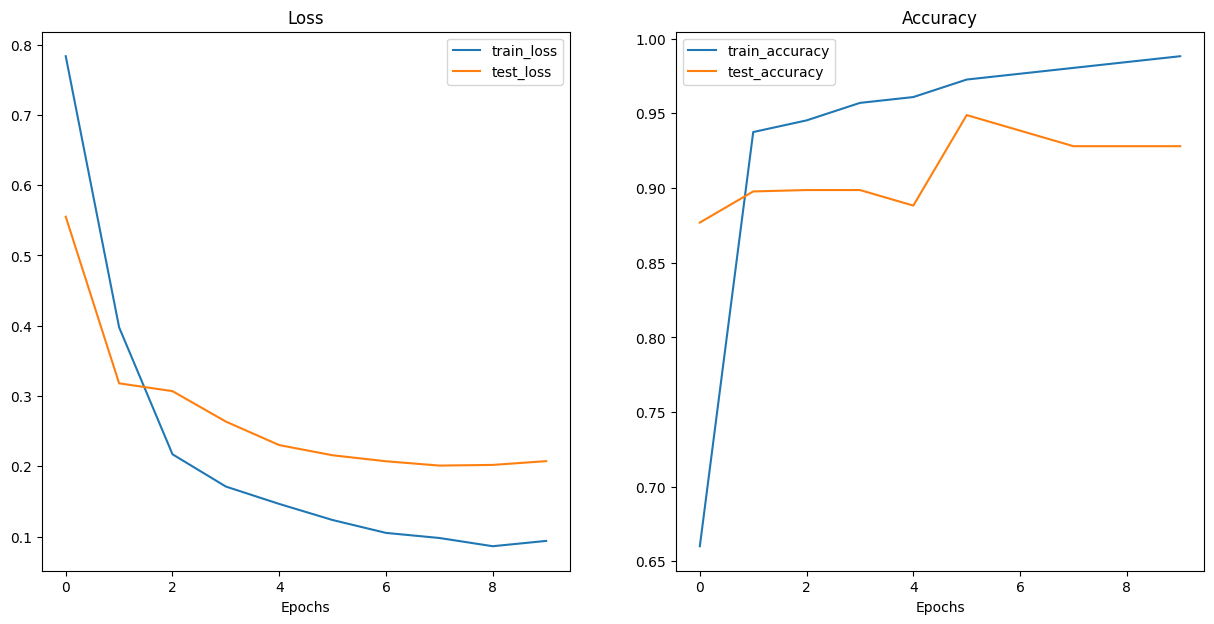

In [71]:
plot_loss_curves(results_1)

### 10.3 Save our best performing VIT Model

Now we have a model that performs weell. Let's save it and check its filesize

In [72]:
# save the model
from going_modular.going_modular import utils

In [73]:
utils.save_model(model=pretrained_vit,
                 target_dir = 'models',
                 model_name = '08_pretrained_vit_feature_extractor.pth')

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor.pth


In [75]:
from pathlib import Path

# get file size in bytes and convert to megatbytes
pretrained_vit_model_size = Path('/content/models/08_pretrained_vit_feature_extractor.pth').stat().st_size // (1024*1024)
print(f'Pretrained VIT model size: {pretrained_vit_model_size} MB')

Pretrained VIT model size: 327 MB


## 11 Predicting on a custom image

In [76]:
# Download a custom image
import requests

# Setup custome image path
data_path = Path('data')
custom_image_path = data_path / '04-pizza-dad.jpeg'

# download image if doesn't exist
if not custom_image_path.is_file():
  with open(custom_image_path, 'wb') as f:
    # when downloading from github use the raw link
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/04-pizza-dad.jpeg?raw=true')
    print(f'Downloading {custom_image_path}')
    f.write(request.content)
else:
  print('File already exist')


In [77]:
from helper_functions import pred_and_plot_image



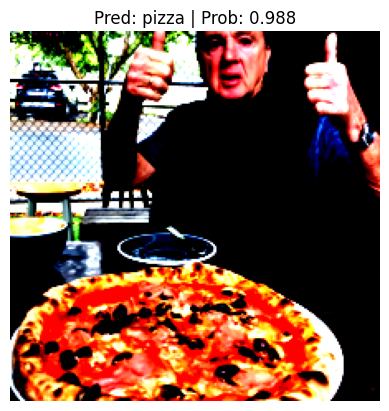

In [82]:
pred_and_plot_image(model=pretrained_vit,
                    image_path = custom_image_path,
                    class_names = class_names,
                    transform = vit_transforms
                    )